In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

Saving alzheimers-dataset-4-class-of-images-metadata (1).json to alzheimers-dataset-4-class-of-images-metadata (1).json
User uploaded file "alzheimers-dataset-4-class-of-images-metadata (1).json" with length 3446 bytes
mv: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 91% 31.0M/34.1M [00:00<00:00, 108MB/s] 
100% 34.1M/34.1M [00:00<00:00, 108MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from zipfile import ZipFile
import os, glob
import cv2
from tqdm.notebook import tqdm  # Corrected import for tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D, BatchNormalization, Flatten
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model  # Corrected import for model plotting
from imblearn.over_sampling import SMOTE
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.15.0


In [ ]:
file_name = "/content/alzheimers-dataset-4-class-of-images.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall("/content/")
    print('Done')
    extracted_dir = "/content/Alzheimer_s Dataset"
print("Contents of extracted directory:")
print(os.listdir(extracted_dir))

Done
Contents of extracted directory:
['test', 'train']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
base_dir = "/content/Alzheimer_s Dataset"
train_dir = os.path.join(extracted_dir, "train")
test_dir = os.path.join(extracted_dir, "test")


In [ ]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']
IMG_SIZE = 299
IMAGE_SIZE = [299, 299]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
BATCH_SIZE = 32

# Set a random seed for reproducibility
seed_value = 1337

# Create separate data generators for training and validation with augmentation
train_datagen = IDG(
    rescale=1./255,
    zoom_range=[.99, 1.01],
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    fill_mode='constant',
    validation_split=0.2,
    data_format='channels_last'
)
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='training',
    seed=seed_value
)

val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # Assuming you're doing multi-class classification
    subset='validation',
    seed=seed_value
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


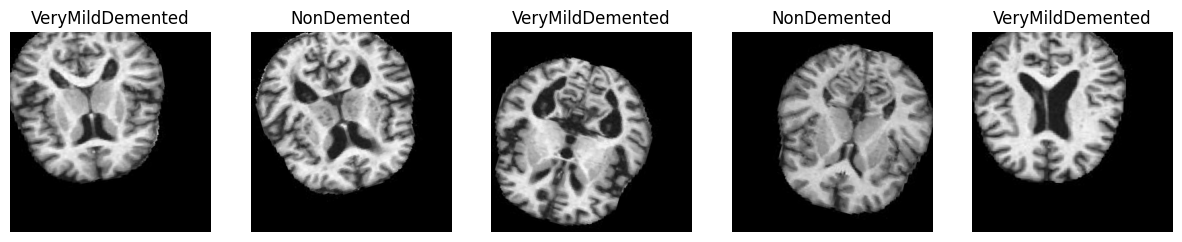

In [ ]:
# Get a batch of images and labels from the training dataset
sample_batch = next(train_ds)

# Extract images and labels from the batch
images, numerical_labels = sample_batch

# Convert numerical labels to class names
class_indices = train_ds.class_indices
class_names = list(class_indices.keys())
class_names = [class_names[num_label] for num_label in numerical_labels.argmax(axis=1)]

# Plot the first 5 images with their corresponding labels
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names[i])
    axes[i].axis("off")

plt.show()

In [ ]:
# Assuming `train_ds` is a NumPy array with a 'class_label' column
#class_labels = train_ds['class_names']

import glob

datasets, Mild_Demented, Moderate_Demented, Non_Demented, VeryMild_Demented = ["train", "test"], [], [], [], []

for dataset in datasets:
    path = os.path.join(extracted_dir, dataset)
    MildDemented = glob.glob(os.path.join(path, "MildDemented/*.jpg"))
    ModerateDemented = glob.glob(os.path.join(path, "ModerateDemented/*.jpg"))
    NonDemented = glob.glob(os.path.join(path, "NonDemented/*.jpg"))
    VeryMildDemented = glob.glob(os.path.join(path, "VeryMildDemented/*.jpg"))
    Mild_Demented.extend(MildDemented)
    Moderate_Demented.extend(ModerateDemented)
    Non_Demented.extend(NonDemented)
    VeryMild_Demented.extend(VeryMildDemented)

print("The number of MildDemented images is:", len(Mild_Demented))
print("The number of ModerateDemented images is:", len(Moderate_Demented))
print("The number of NonDemented images is:", len(Non_Demented))
print("The number of VeryMildDemented images is:", len(VeryMild_Demented))

The number of MildDemented images is: 896
The number of ModerateDemented images is: 64
The number of NonDemented images is: 3200
The number of VeryMildDemented images is: 2240


In [ ]:
import seaborn as sns

<ipython-input-15-3c5cd066482a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')


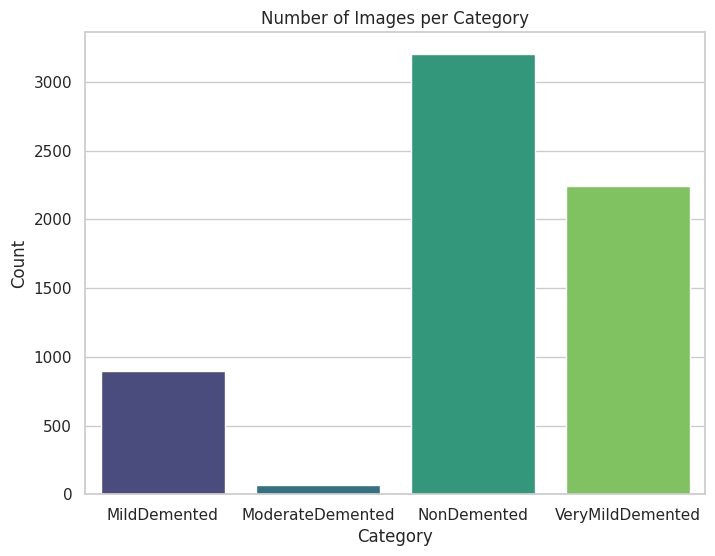

In [ ]:

# Prepare the data for plotting
data = {
    'Category': ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'],
    'Count': [len(Mild_Demented), len(Moderate_Demented), len(Non_Demented), len(VeryMild_Demented)]
}

# Create a bar plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()


In [ ]:
total_samples = len(Mild_Demented) + len(Moderate_Demented) + len(Non_Demented) + len(VeryMild_Demented)
class_weights = {
    0: total_samples / (4 * len(Mild_Demented)),
    1: total_samples / (4 * len(ModerateDemented)),
    2: total_samples / (4 * len(NonDemented)),
    3: total_samples / (4 * len(VeryMildDemented))
}

In [ ]:
#inception model done by farah
inception_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

for layer in inception_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


In [ ]:
custom_inception_model = Sequential([
    inception_model,
    Dropout(0.5),
    GlobalAveragePooling2D(),
    Flatten(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name="inception_cnn_model")

In [ ]:
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

custom_inception_model.compile(optimizer='adam',
                               loss=tf.losses.CategoricalCrossentropy(),
                               metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 8, 8, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_149 (B  (None, 2048)              8192      
 atchNormalization)                                              
                                                                 
 dense (Dense)               (None, 512)       

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                   save_best_only=True)


In [ ]:
history = custom_inception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_cb, lr_scheduler]
)


Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 6.5143 - acc: 0.3216 - auc: 0.6101 - f1_score: 0.2274

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 152s 1s/step - loss: 6.5143 - acc: 0.3216 - auc: 0.6101 - f1_score: 0.2274 - val_loss: 1.3209 - val_acc: 0.3715 - val_auc: 0.6821 - val_f1_score: 0.2312 - lr: 0.0100
Epoch 2/30
129/129 [==============================] - 113s 870ms/step - loss: 5.3998 - acc: 0.3782 - auc: 0.6672 - f1_score: 0.2400 - val_loss: 1.3242 - val_acc: 0.3871 - val_auc: 0.6770 - val_f1_score: 0.2437 - lr: 0.0089
Epoch 3/30
129/129 [==============================] - 111s 864ms/step - loss: 4.7093 - acc: 0.3990 - auc: 0.6776 - f1_score: 0.2477 - val_loss: 1.2267 - val_acc: 0.4076 - val_auc: 0.7180 - val_f1_score: 0.2519 - lr: 0.0079
Epoch 4/30
129/129 [==============================] - 113s 879ms/step - loss: 4.2893 - acc: 0.4122 - auc: 0.7055 - f1_score: 0.2562 - val_loss: 1.1701 - val_acc: 0.4379 - val_auc: 0.7412 - val_f1_score: 0.2805 - lr: 0.0071
Epoch 5/30
129/129 [==============================] - 111s 858ms/step - loss: 3.9992 - acc: 0.4373 - auc: 0.7313 - f1_scor

In [ ]:
custom_inception_model.save('/content/drive/MyDrive/colab run')

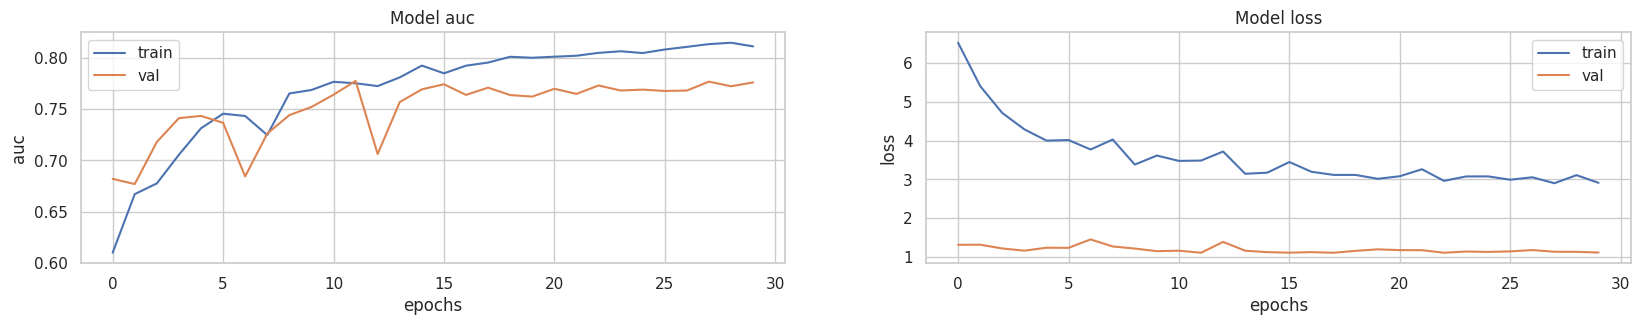

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Unfreeze some layers for additional fine-tuning
for layer in inception_model.layers[-20:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
custom_inception_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

In [ ]:
history_fine = custom_inception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,  # Further fine-tuning epochs
    callbacks=[checkpoint_cb, lr_scheduler]
)


NameError: name 'custom_inception_model' is not defined

In [ ]:
# Assuming model is your trained model and test_ds is your test dataset
test_results = custom_inception_model.evaluate(test_ds)

# The evaluate method returns a list of metrics, and you can print or use them as needed
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

8/8 [==============================] - 13s 2s/step - loss: 1.0286 - acc: 0.5512 - auc: 0.8050 - f1_score: 0.3406
Test Loss: 1.0285584926605225
Test Accuracy: 0.5511810779571533


In [ ]:
#applying fine tuning

In [ ]:
# Fine-tuning: unfreeze some layers and continue training
for layer in inception_model.layers[-20:]:
    layer.trainable = True

custom_inception_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                               loss=tf.losses.CategoricalCrossentropy(),
                               metrics=METRICS)


In [ ]:

history_fine = custom_inception_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)

Epoch 1/10
129/129 [==============================] - ETA: 0s - loss: 1.2956 - acc: 0.4360 - auc: 0.7250 - f1_score: 0.2780

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 179s 937ms/step - loss: 1.2956 - acc: 0.4360 - auc: 0.7250 - f1_score: 0.2780 - val_loss: 1.1834 - val_acc: 0.4379 - val_auc: 0.7440 - val_f1_score: 0.2806
Epoch 2/10
129/129 [==============================] - 113s 880ms/step - loss: 1.2877 - acc: 0.4161 - auc: 0.7091 - f1_score: 0.2660 - val_loss: 1.2361 - val_acc: 0.4125 - val_auc: 0.7207 - val_f1_score: 0.2682
Epoch 3/10
129/129 [==============================] - 113s 877ms/step - loss: 1.2745 - acc: 0.4226 - auc: 0.7129 - f1_score: 0.2702 - val_loss: 1.2244 - val_acc: 0.4125 - val_auc: 0.7246 - val_f1_score: 0.2625
Epoch 4/10
129/129 [==============================] - 115s 889ms/step - loss: 1.2668 - acc: 0.4314 - auc: 0.7177 - f1_score: 0.2740 - val_loss: 1.2128 - val_acc: 0.4154 - val_auc: 0.7263 - val_f1_score: 0.2633
Epoch 5/10
129/129 [==============================] - 115s 894ms/step - loss: 1.2511 - acc: 0.4209 - auc: 0.7197 - f1_score: 0.2655 - val_loss: 1.1961 - val_acc: 0.4282 - 

In [ ]:
custom_inception_model.save('/content/drive/MyDrive/trainingfinetunningone')

In [ ]:

# Evaluate the model
test_ds = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=seed_value
)
test_results = custom_inception_model.evaluate(test_ds)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 28s 675ms/step - loss: 1.1881 - acc: 0.4902 - auc: 0.7630 - f1_score: 0.2675
Test Loss: 1.1880502700805664
Test Accuracy: 0.49022674560546875


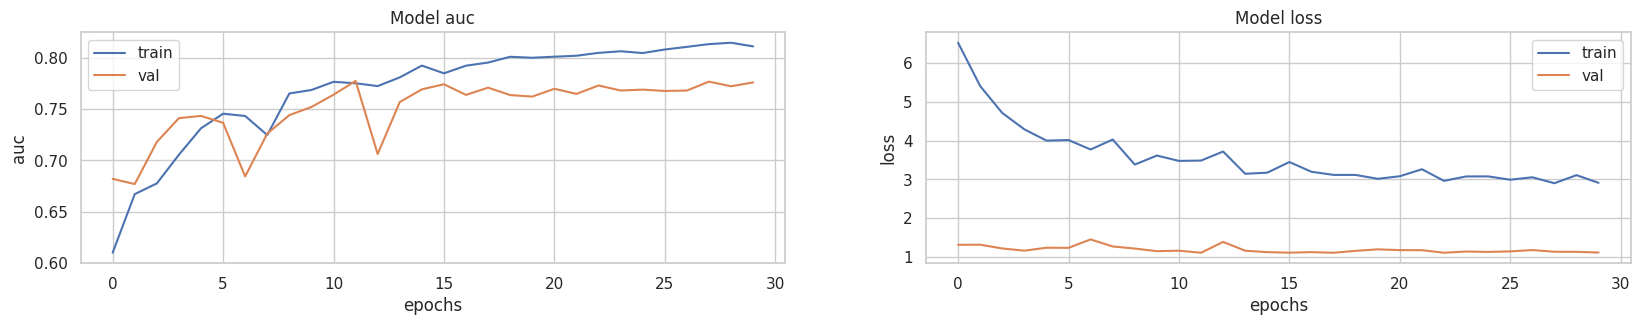

In [ ]:
# Plot training history
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


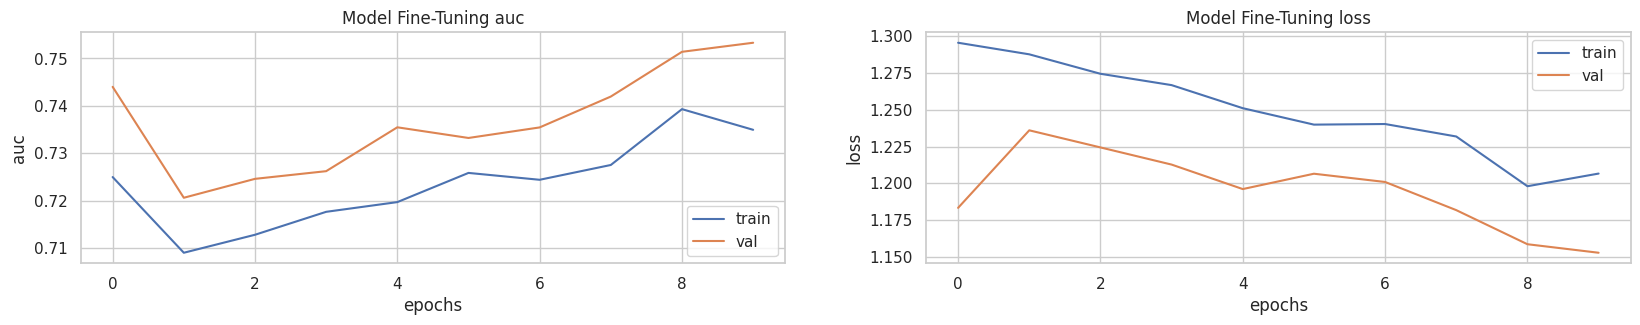

In [ ]:
# Plot fine-tuning history
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_fine.history[met])
    ax[i].plot(history_fine.history['val_' + met])
    ax[i].set_title('Model Fine-Tuning {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
train_datagen = IDG(
    rescale=1./255,
    zoom_range=[.99, 1.01],
    horizontal_flip=True,
    fill_mode='constant',
    validation_split=0.2
)


In [ ]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=1337
)

val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=1337
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.


In [ ]:
# Display sample images
sample_batch = next(train_ds)
images, numerical_labels = sample_batch
class_indices = train_ds.class_indices
class_names = list(class_indices.keys())
class_names = [class_names[num_label] for num_label in numerical_labels.argmax(axis=1)]

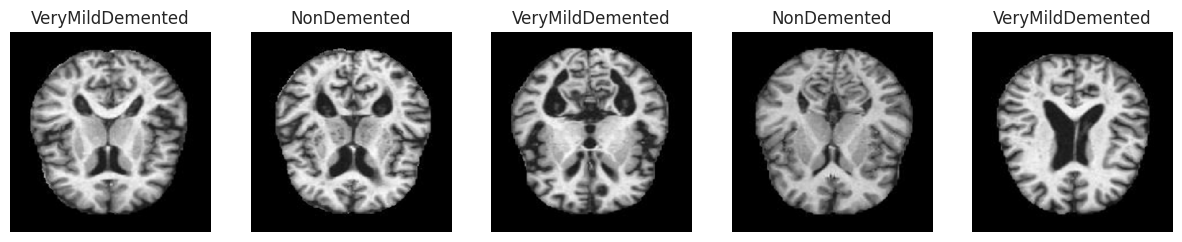

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].set_title(class_names[i])
    axes[i].axis("off")
plt.show()

In [ ]:
# Count images per category
datasets = ["train", "test"]
counts = {cls: 0 for cls in CLASSES}
for dataset in datasets:
    for cls in CLASSES:
        counts[cls] += len(glob.glob(os.path.join(extracted_dir, dataset, cls, '*.jpg')))

<ipython-input-31-6422e1190ee8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')


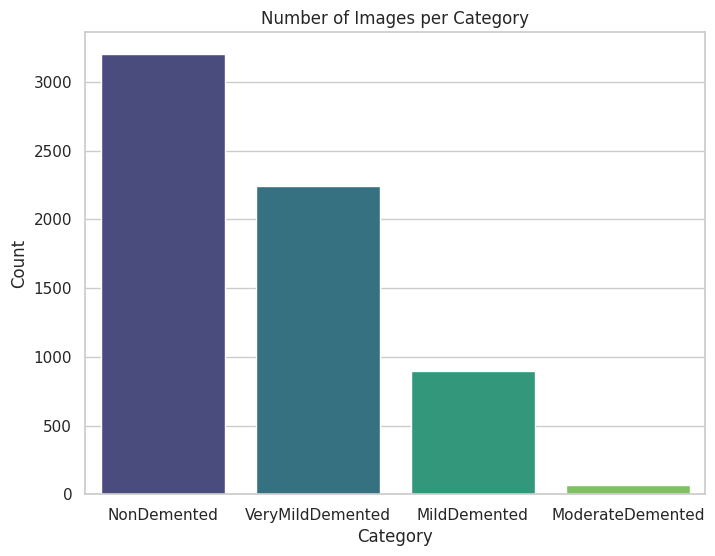

In [ ]:
data = {'Category': list(counts.keys()), 'Count': list(counts.values())}
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Category', y='Count', data=data, palette='viridis')
ax.set_title('Number of Images per Category')
plt.show()

In [ ]:
# Class weights
total_samples = sum(counts.values())
class_weights = {i: total_samples / (4 * count) for i, count in enumerate(counts.values())}

In [ ]:
# Load and prepare InceptionV3 model
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Custom model on top of InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
# Define learning rate scheduler and other callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
checkpoint_cb = ModelCheckpoint("inceptionv3_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Compile the model
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=4)
]

model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=METRICS)

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_99 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_99

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[lr_schedvuler, checkpoint_cb, early_stopping_cb],
    class_weight=class_weights
)


NameError: name 'model' is not defined

In [ ]:
# Evaluate the model on the test set
test_ds = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=1337
)

In [ ]:
test_results = model.evaluate(test_ds)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])
print("Test AUC:", test_results[2])


In [ ]:
# Plot training history
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax = ax.ravel()

In [ ]:
for i, met in enumerate(['accuracy', 'auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(f'Model {met.capitalize()}')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())
    ax[i].legend(['Train', 'Validation'])

plt.show()

In [ ]:
#Nada ayman
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Initialize a Sequential model
model = Sequential()

In [ ]:
# Add the first convolutional layer
model.add(Convolution2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add a second convolutional layer
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Add a fully connected layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))


In [ ]:
# Add the output layer
model.add(Dense(len(CLASSES), activation='softmax'))


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 64)                2

In [ ]:
# Set up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [ ]:
# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=train_ds.samples // BATCH_SIZE,
    epochs=50,
    validation_data=val_ds,
    validation_steps=val_ds.samples // BATCH_SIZE,
    class_weight=class_weights,  # Utilize the calculated class weights
    callbacks=[reduce_lr]
)

Epoch 1/50
128/128 [==============================] - 733s 6s/step - loss: 1.3984 - accuracy: 0.3487 - val_loss: 1.3806 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 2/50
 16/128 [==>...........................] - ETA: 9:48 - loss: 1.3763 - accuracy: 0.3652